In [1]:
import numpy as np
import nengo
import nengolib
from nengo_extras.plot_spikes import cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Parameters

In [242]:
seed = 0
rng = np.random.RandomState(seed)
n_items = 6
d = 2
n_pre = 105
n_neurons = 100
n_inh = 95
n_bias = 90
dt = 0.001
t = 1.0
n_cycles = 20
T = t*n_items*n_cycles
items = nengolib.stats.ScatteredHypersphere(surface=True).sample(n_items, d, rng=rng)

### Present inputs in a cyclic pattern, with order randomized every cycle

In [243]:
def make_stim():
    stim = np.zeros((int(T/dt)+2, d))
    time = 0
    for i in range(n_cycles):
        order = np.arange(0, n_items)
        rng.shuffle(order)
        for j in range(n_items):
            for k in range(int(t/dt)):
                stim[time] = items[order[j]]
                time += 1
    return stim

stim = make_stim()

def stim_func(t, dt=0.001):
    return stim[int(t/dt)]

# 1. Generate decoders for ```pre```, use VOJA learning rule to sparsify encoders for ```target```, and use PES learning to decode ```target``` activities

In [244]:
learning_rate_voja = 1e-3
learning_rate_pes = 1e-4
synapse = nengo.Lowpass(0.01)
smooth = nengolib.DoubleExp(2e-2, 2e-1)
intercept = (np.dot(items, items.T) - np.eye(n_items)).flatten().max() # from Step 1 of https://www.nengo.ai/nengo/examples/learning/learn-associations.html
intercepts = nengo.dists.Uniform(intercept, 1)
max_rates = nengo.dists.Uniform(200, 400)

In [263]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
 
    voja = nengo.Voja(learning_rate=learning_rate_voja, post_synapse=None)
    pes = nengo.PES(learning_rate=learning_rate_pes)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    bias = nengo.Ensemble(n_bias, d, seed=seed+2)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, learning_rule_type=voja)
    bias_target = nengo.Connection(bias, target, synapse=synapse)
    target_output = nengo.Connection(target, output, synapse=synapse, learning_rule_type=pes, function=lambda x: np.zeros(d))
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, target_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_encoders = nengo.Probe(pre_target.learning_rule, "scaled_encoders")
    p_decoders = nengo.Probe(target_output, "weights")
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [264]:
d_pre = sim.data[pre_target].weights
d_bias = sim.data[bias_target].weights
e_target = sim.data[p_encoders][-1].copy()
d_target = sim.data[p_decoders][-1].copy()
w_pre_target = np.dot(e_target, d_pre)

Confirm encoder learning has sparsified ```target```. Encoders should be clustered around the items defined in Model Parameters

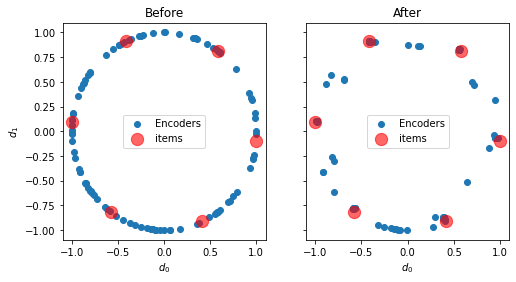

In [265]:
scale = (sim.data[target].gain / target.radius)[:, np.newaxis]
encoders_before = sim.data[p_encoders][0].copy() / scale
encoders_after = sim.data[p_encoders][-1].copy() / scale
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((8, 4)))
ax.scatter(encoders_before[:, 0], encoders_before[:, 1], label="Encoders")
ax.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax2.scatter(encoders_after[:, 0], encoders_after[:, 1], label="Encoders")
ax2.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax.set(xlabel=r'$d_0$', ylabel=r'$d_1$', title='Before')
ax2.set(xlabel=r'$d_0$', title='After')
ax.legend(loc='best')
ax2.legend(loc='best')

This should also be reflected in the spike rasters

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

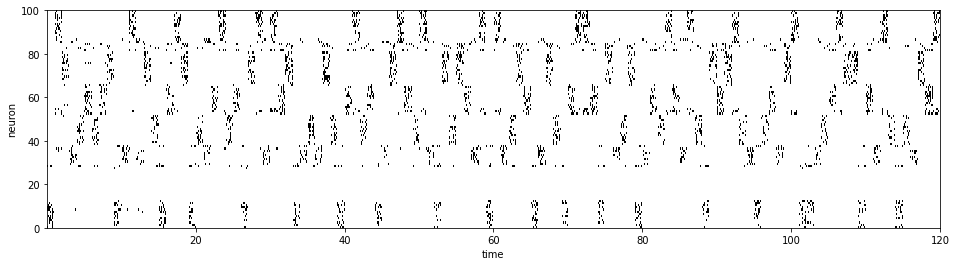

In [266]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_target], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

Confirm that an estimate of the input ```items``` can be recovered from ```target```

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

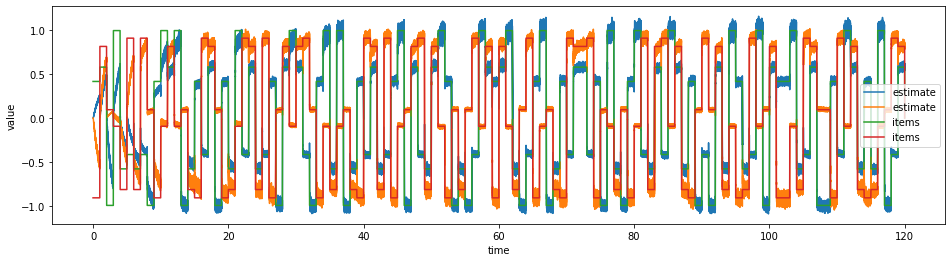

In [267]:
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

Test with learning removed

In [268]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
 
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    target_output = nengo.Connection(target, output, synapse=synapse, solver=nengo.solvers.NoSolver(d_target.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

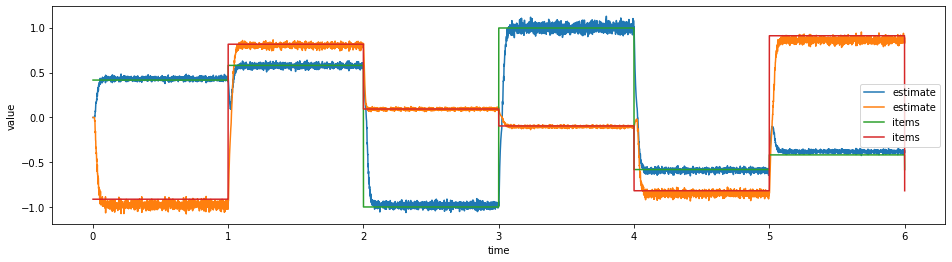

In [269]:
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

# 2. Define a custom node to implement a connection and a learning rule

In [270]:
class CustomLearningNode(nengo.Node):
    def __init__(self, pre, post, target, d_pre, learning_rate, exc=False, inh=False):
        self.pre = pre
        self.post = post
        self.target = target
        self.size_in = pre.n_neurons + post.n_neurons + target.n_neurons
        self.size_out = post.n_neurons
        self.d_pre = d_pre
        # 'encoders' is a connection-specific tensor used to compute weights; shape (Npre, Npost, d)
        self.e_post = np.zeros((pre.n_neurons, post.n_neurons, d_pre.shape[1]))
        self.weights = np.zeros((pre.n_neurons, post.n_neurons))
        self.learning_rate = learning_rate
        self.exc = exc
        self.inh = inh
        assert self.exc==False or self.inh==False, "Can't force excitatory and inhibitory weights"
        super().__init__(self.step, size_in=self.size_in, size_out=self.size_out)

    def step(self, t, x, update_every=10, dt=1e-3, dAmin=1e0):
        a_pre = x[:self.pre.n_neurons]  # divide inputs to node into corresponding activities
        a_post = x[self.pre.n_neurons: self.pre.n_neurons+self.post.n_neurons]
        a_target = x[self.pre.n_neurons+self.post.n_neurons:]
        if int(t/dt) % update_every == 0: # only update periodically (expensive computation)
            for post in range(self.post.n_neurons):
                dA = a_target[post] - a_post[post]
                if np.abs(dA)<dAmin: continue  # skip update if post activity is close to target activity
                for pre in range(self.pre.n_neurons):
                    for dim in range(self.d_pre.shape[1]): # each dimension of the 'encoder' is updated separately
                        sign = 1.0 if self.d_pre[pre, dim] >= 0 else -1.0 # sign ensures weight change is in the correct direction
                        dE = sign * self.learning_rate * a_pre[pre] # delta for that entry in the encoder matrix
                        self.e_post[pre, post, dim] += dA * dE
                    w = np.dot(self.d_pre[pre], self.e_post[pre, post]) # update corresponding entry in weight matrix
                    if self.exc and w < 0: w = 0 # enforce excitatory weights
                    if self.inh and w > 0: w = 0 # enforce inhibitory weights
                    self.weights[pre, post] = w # update weight matrix
        return np.dot(self.weights.T, a_pre)  # transmit weighted activity from pre to post

# 3. Train the weights on the ```pre-post``` connection so that ```post```'s activities converge to ```target```'s activities; also train readout decoders for ```post``` with PES

In [307]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    bias = nengo.Ensemble(n_bias, d, seed=seed+2)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, seed=seed+3, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    pes = nengo.PES(learning_rate=learning_rate_pes)
    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 1e-7)
    learning_node_bias = CustomLearningNode(bias, post, target, d_bias.T, 3e-8)

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)

    nengo.Connection(bias.neurons, learning_node_bias[:bias.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node_bias[bias.n_neurons: bias.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node_bias[bias.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_bias, post.neurons, synapse=None)
                          
    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    post_output = nengo.Connection(post, output, synapse=synapse, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_decoders = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [308]:
d_post = sim.data[p_decoders][-1].copy()
w_pre_post = learning_node.weights
w_bias_post = learning_node_bias.weights

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

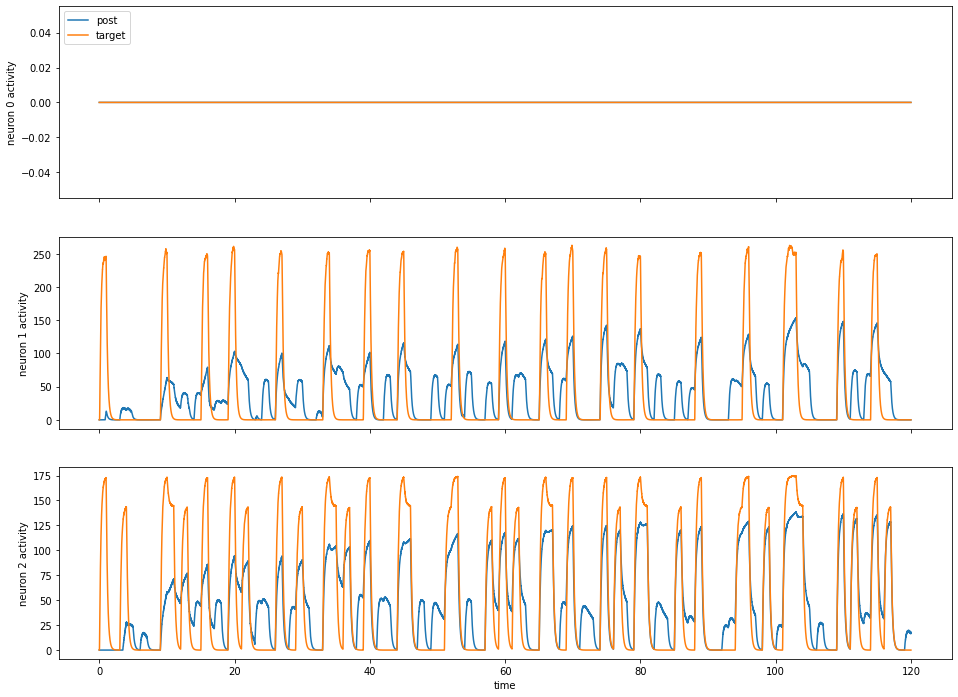

In [309]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Test with learning removed

In [310]:
w_pre_post = learning_node.weights.copy()

with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    bias = nengo.Ensemble(n_bias, d, seed=seed+2)
    post = nengo.Ensemble(n_neurons, d, seed=seed+3, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    bias_post = nengo.Connection(bias, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_bias_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=synapse, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

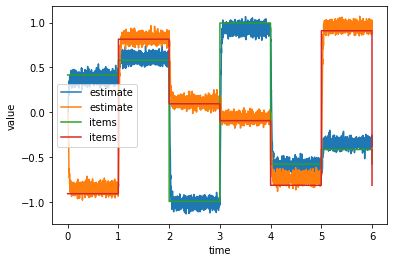

In [311]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

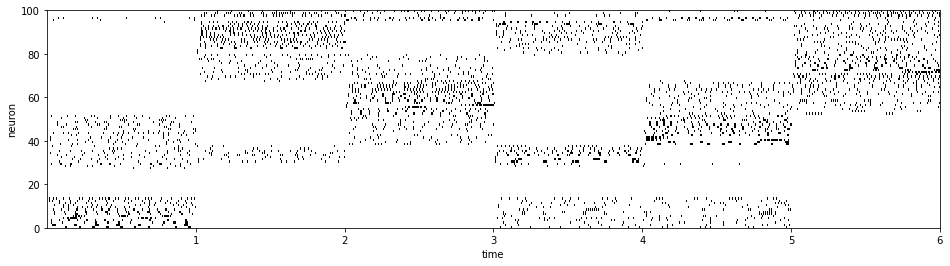

In [312]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_post], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

# 4. Specify an adaptive neuron type for ```post```. Use ```DoubleExp``` synapses with AMPA parameters for excitatory connections from ```pre``` to ```post``` 

In [18]:
AMPA = nengolib.synapses.DoubleExp(0.55e-3, 2.2e-3)
post_type = nengo.Izhikevich()  # todo: find biological parameters

t = 1.0
n_cycles = 10
T = t*n_items*n_cycles
stim = make_stim()

In [19]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    pes = nengo.PES(learning_rate=learning_rate_pes)
    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-6, exc=True)

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=AMPA)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_node = nengo.Probe(learning_node, synapse=None)
    p_decoders = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [20]:
d_post = sim.data[p_decoders][-1].copy()
w_pre_post = learning_node.weights

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

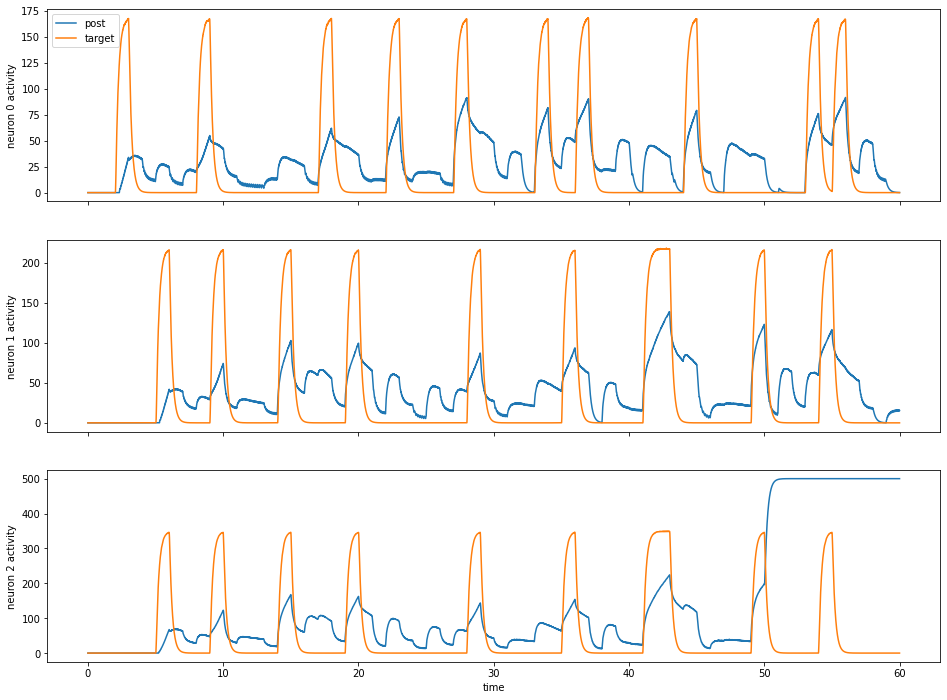

In [21]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Test with learning removed

In [22]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

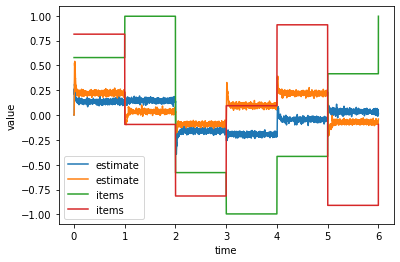

In [23]:
a_post = synapse.filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_post.T)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

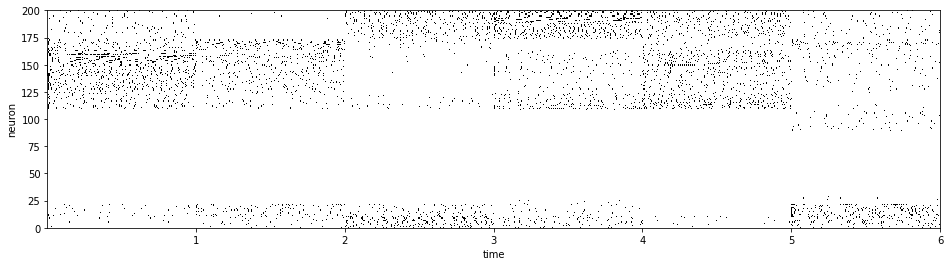

In [24]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_post], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

# 5. Train a connection between ```post``` and a new inhibitory population ```inh``` with NMDA synapses so that ```inh``` approaches the activity of ```target_inh```. Learn the ```post-inh``` and ```inh-post``` connection weights at the same time as the ```pre-post``` connection.

In [25]:
NMDA = nengolib.synapses.DoubleExp(10.6e-3, 285e-3)
GABA = nengolib.synapses.DoubleExp(0.5e-3, 1.5e-3)
AMPA = nengolib.synapses.DoubleExp(0.55e-3, 2.2e-3)
smooth = nengolib.synapses.DoubleExp(1e-3, 2e-1)
post_type = nengo.Izhikevich()  # todo: find biological parameters
inh_type = nengo.Izhikevich(tau_recovery=0.1)  # todo: find biological parameters
learning_rate_voja_post = 3e-2
learning_rate_voja_inh = 6e-2
learning_rate_pes = 3e-3
n_post = 200
n_inh = 205
n_pre = 195

In [26]:
intercept_min = (np.dot(items, items.T) - np.eye(n_items)).flatten().max() # from Step 1 of https://www.nengo.ai/nengo/examples/learning/learn-associations.html
above_min = 0.1
intercepts = nengo.dists.Uniform(intercept_min+above_min, 1)
max_rates_post = nengo.dists.Uniform(20, 40)
max_rates_inh = nengo.dists.Uniform(10, 30)

### 5.1 Learn encoders for ```target_post``` and ```target_inh``` using VOJA

In [27]:
with nengo.Network() as network:
    # inputs, outputs, error populations, and ensembles
    input = nengo.Node(stim_func)
    output_post = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    output_inh = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error_post = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error_inh = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target_post = nengo.Ensemble(n_post, d, intercepts=intercepts, max_rates=max_rates_post, seed=seed+1)
    target_inh = nengo.Ensemble(n_inh, d, intercepts=intercepts, max_rates=max_rates_inh, seed=seed+1)

    # VOJA and PES learning rules
    pes = nengo.PES(learning_rate=learning_rate_pes)
    voja_post = nengo.Voja(learning_rate=learning_rate_voja_post, post_synapse=AMPA)
    voja_inh = nengo.Voja(learning_rate=learning_rate_voja_inh, post_synapse=GABA)

    # feedforward connections with encoder learning
    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target_post = nengo.Connection(pre, target_post, synapse=AMPA, learning_rule_type=voja_post)
    pre_target_inh = nengo.Connection(pre, target_inh, synapse=AMPA, learning_rule_type=voja_inh)

    # feedforward connections with decoder learning
    post_output = nengo.Connection(target_post, output_post, synapse=NMDA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_post, d))))
    input_error_post = nengo.Connection(input, error_post, transform=-1, synapse=None)
    output_error_post = nengo.Connection(output_post, error_post, synapse=None)
    error_signal_post = nengo.Connection(error_post, post_output.learning_rule, synapse=None)
    inh_output = nengo.Connection(target_inh, output_inh, synapse=GABA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_inh, d))))
    input_error_inh = nengo.Connection(input, error_inh, transform=-1, synapse=None)
    output_error_inh = nengo.Connection(output_inh, error_inh, synapse=None)
    error_signal_inh = nengo.Connection(error_inh, inh_output.learning_rule, synapse=None)
    
    # probes
    p_input = nengo.Probe(input, synapse=None)
    p_target_post = nengo.Probe(target_post.neurons, synapse=None)
    p_target_inh = nengo.Probe(target_inh.neurons, synapse=None)
    p_output_post = nengo.Probe(output_post, synapse=None)
    p_output_inh = nengo.Probe(output_inh, synapse=None)
    p_encoders_post = nengo.Probe(pre_target_post.learning_rule, "scaled_encoders")
    p_encoders_inh = nengo.Probe(pre_target_inh.learning_rule, "scaled_encoders")
    p_decoders_post = nengo.Probe(post_output, "weights")
    p_decoders_inh = nengo.Probe(inh_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

d_pre_post = sim.data[pre_target_post].weights
d_pre_inh = sim.data[pre_target_inh].weights
d_target_post = sim.data[p_decoders_post][-1].copy()
d_target_inh = sim.data[p_decoders_inh][-1].copy()
e_target_post = sim.data[p_encoders_post][-1].copy()
e_target_inh = sim.data[p_encoders_inh][-1].copy()
w_pre_target_post = np.dot(e_target_post, d_pre_post)
w_pre_target_inh = np.dot(e_target_inh, d_pre_inh)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

```target_post``` encoders, raster, readout

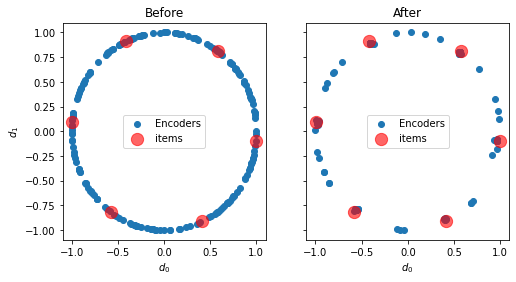

In [28]:
scale = (sim.data[target_post].gain / target_post.radius)[:, np.newaxis]
encoders_before = sim.data[p_encoders_post][0].copy() / scale
encoders_after = sim.data[p_encoders_post][-1].copy() / scale
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((8, 4)))
ax.scatter(encoders_before[:, 0], encoders_before[:, 1], label="Encoders")
ax.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax2.scatter(encoders_after[:, 0], encoders_after[:, 1], label="Encoders")
ax2.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax.set(xlabel=r'$d_0$', ylabel=r'$d_1$', title='Before')
ax2.set(xlabel=r'$d_0$', title='After')
ax.legend(loc='best')
ax2.legend(loc='best')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

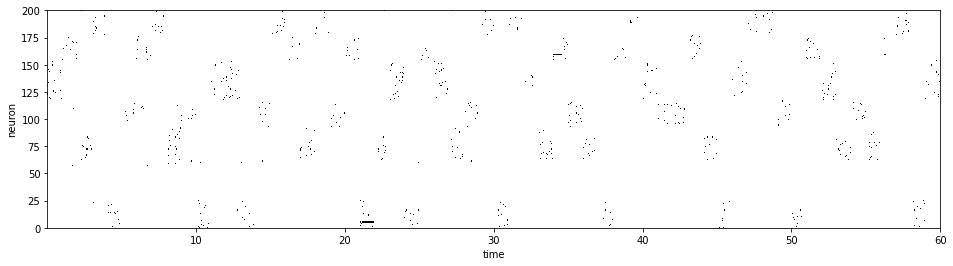

In [29]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_target_post], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

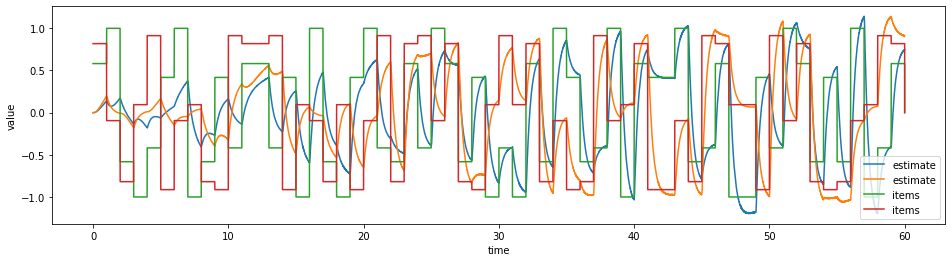

In [30]:
estimate = sim.data[p_output_post]
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

```target_inh``` encoders, raster, readout

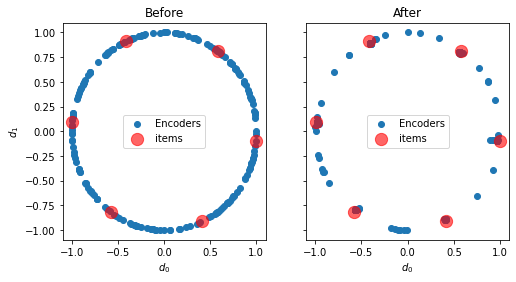

In [31]:
scale = (sim.data[target_inh].gain / target_inh.radius)[:, np.newaxis]
encoders_before = sim.data[p_encoders_inh][0].copy() / scale
encoders_after = sim.data[p_encoders_inh][-1].copy() / scale
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((8, 4)))
ax.scatter(encoders_before[:, 0], encoders_before[:, 1], label="Encoders")
ax.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax2.scatter(encoders_after[:, 0], encoders_after[:, 1], label="Encoders")
ax2.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax.set(xlabel=r'$d_0$', ylabel=r'$d_1$', title='Before')
ax2.set(xlabel=r'$d_0$', title='After')
ax.legend(loc='best')
ax2.legend(loc='best')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

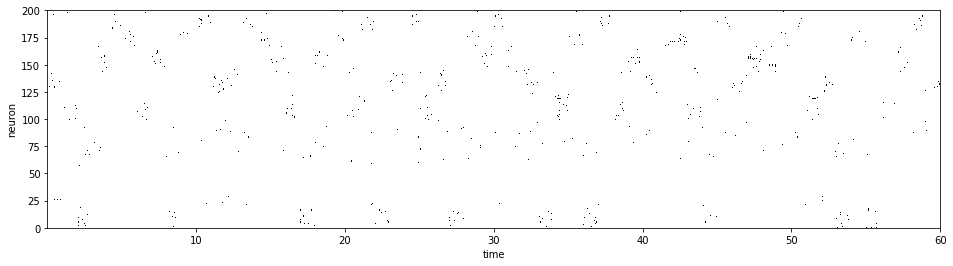

In [32]:
fig, ax = plt.subplots(figsize=((16, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_target_inh], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

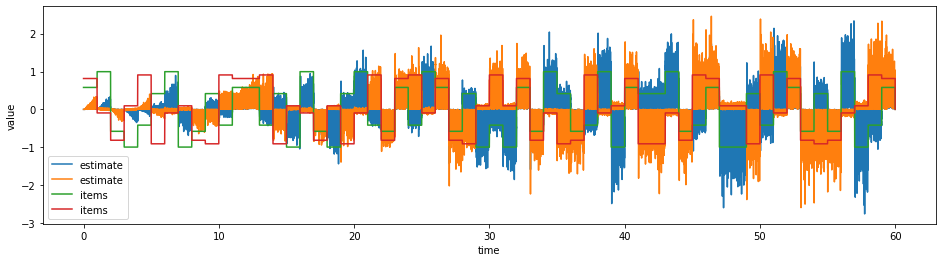

In [33]:
estimate = sim.data[p_output_inh]
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

### 5.2 Train all connections simultaneously
Use ```d_target_post``` and ```d_target_inh``` as appropriate decoders for ```post``` and ```inh``` when doing encoder learning for ```post-inh``` and ```inh-post```

In [34]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    
    target_post = nengo.Ensemble(n_post, d, intercepts=intercepts, max_rates=max_rates_post, seed=seed+1)
    target_inh = nengo.Ensemble(n_inh, d, intercepts=intercepts, max_rates=max_rates_inh, seed=seed+1)
    post = nengo.Ensemble(n_post, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_post)), bias=np.zeros((n_post)))
    inh = nengo.Ensemble(n_inh, d, neuron_type=inh_type, seed=seed+2, gain=np.ones((n_inh)), bias=np.zeros((n_inh)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target_post = nengo.Connection(pre, target_post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_target_post.T, weights=True))
    pre_target_inh = nengo.Connection(pre, target_inh, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_target_inh.T, weights=True))
    
    learning_node_pre_post = CustomLearningNode(pre, post, target_post, d_pre_post.T, 3e-6, exc=True)
    learning_node_post_inh = CustomLearningNode(post, inh, target_inh, d_target_post.T, 1e-5, exc=True)
    learning_node_inh_post = CustomLearningNode(inh, post, target_post, d_target_inh.T, 6e-6, inh=True)

    nengo.Connection(pre.neurons, learning_node_pre_post[:pre.n_neurons], synapse=AMPA)
    nengo.Connection(post.neurons, learning_node_pre_post[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target_post.neurons, learning_node_pre_post[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_pre_post, post.neurons, synapse=None)

    nengo.Connection(post.neurons, learning_node_post_inh[:post.n_neurons], synapse=NMDA)
    nengo.Connection(inh.neurons, learning_node_post_inh[post.n_neurons: post.n_neurons+inh.n_neurons], synapse=smooth)
    nengo.Connection(target_inh.neurons, learning_node_post_inh[post.n_neurons+inh.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_post_inh, inh.neurons, synapse=None)
    
    nengo.Connection(inh.neurons, learning_node_inh_post[:inh.n_neurons], synapse=GABA)
    nengo.Connection(post.neurons, learning_node_inh_post[inh.n_neurons: inh.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target_post.neurons, learning_node_inh_post[inh.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_inh_post, post.neurons, synapse=None)
    
    post_output = nengo.Connection(post, output, synapse=AMPA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_post, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)

    
    p_input = nengo.Probe(input, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_target_post = nengo.Probe(target_post.neurons, synapse=None)
    p_target_inh = nengo.Probe(target_inh.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_inh = nengo.Probe(inh.neurons, synapse=None)
    p_decoders_post = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [35]:
w_pre_post = learning_node_pre_post.weights
w_post_inh = learning_node_post_inh.weights
w_inh_post = learning_node_inh_post.weights
d_post = sim.data[p_decoders_post][-1].copy()

Are ```post``` and ```inh``` activities approaching ```target_post``` and ```target_inh```?

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

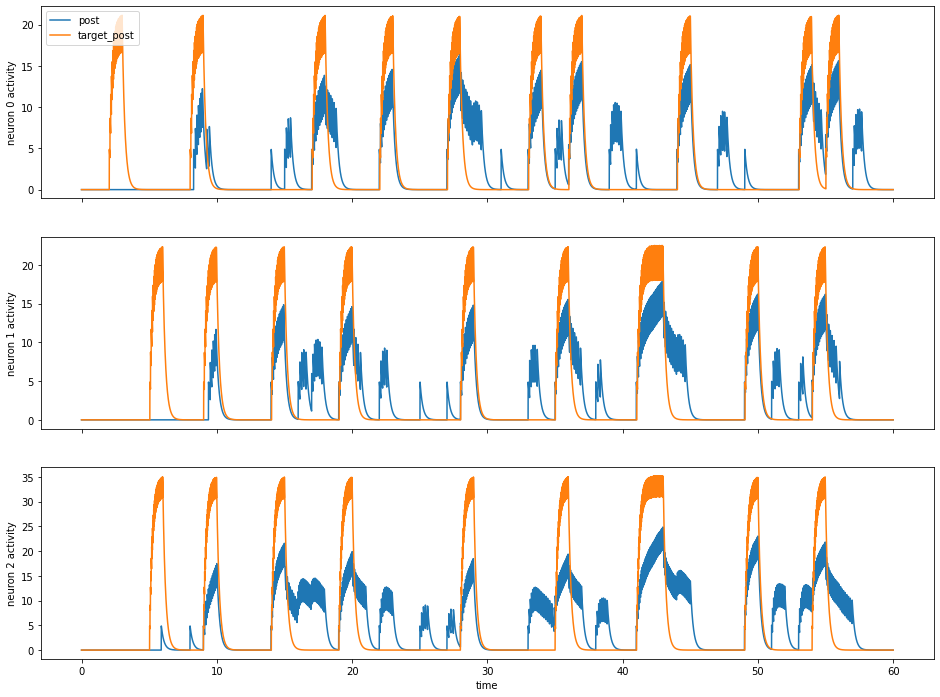

In [36]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,0], label='target_post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,1], label='target_post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,2], label='target_post')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

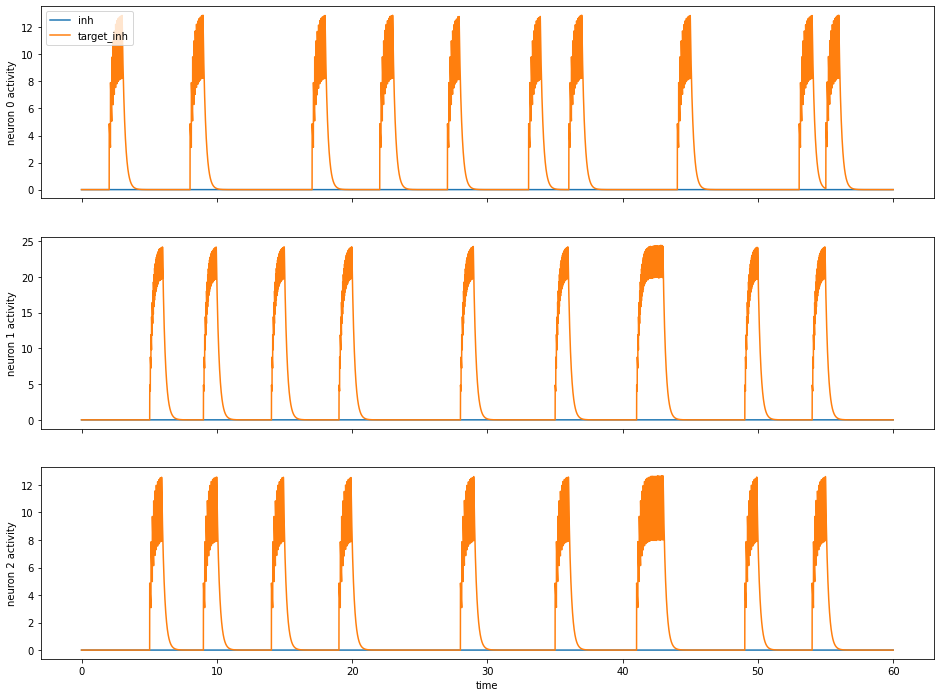

In [37]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_inh], dt=dt)[:,0], label='inh')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target_inh], dt=dt)[:,0], label='target_inh')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_inh], dt=dt)[:,1], label='inh')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target_inh], dt=dt)[:,1], label='target_inh')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_inh], dt=dt)[:,2], label='inh')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target_inh], dt=dt)[:,2], label='target_inh')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value'), (-1.0, 1.0)]

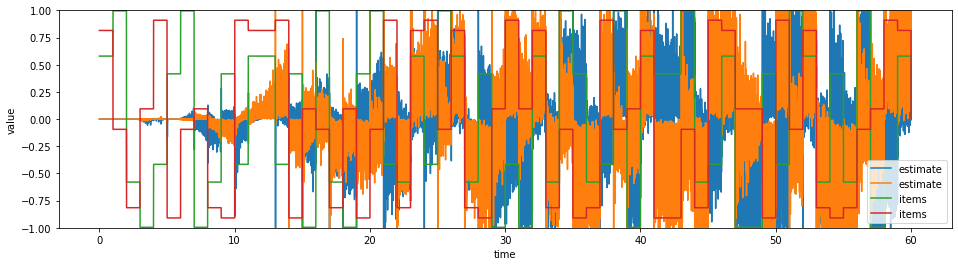

In [38]:
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value', ylim=((-1, 1)))

### 5.3 Test with learning removed

In [39]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct()) 
    post = nengo.Ensemble(n_post, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_post)), bias=np.zeros((n_post)))
    inh = nengo.Ensemble(n_inh, d, neuron_type=inh_type, seed=seed+2, gain=np.ones((n_inh)), bias=np.zeros((n_inh)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    post_inh = nengo.Connection(post, inh, synapse=NMDA, solver=nengo.solvers.NoSolver(w_post_inh, weights=True))
    inh_post = nengo.Connection(inh, post, synapse=GABA, solver=nengo.solvers.NoSolver(w_inh_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_inh = nengo.Probe(inh.neurons, synapse=None)

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value'), (-1.0, 1.0)]

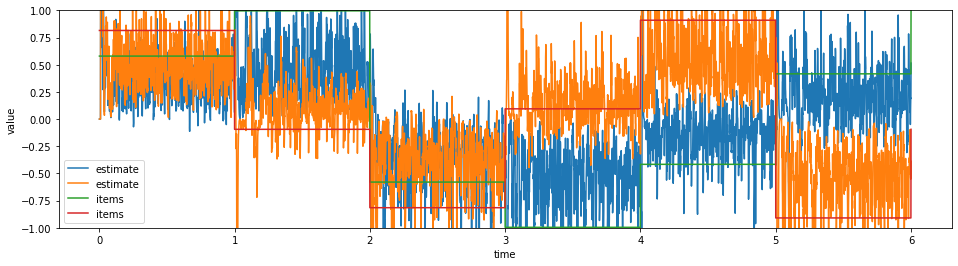

In [40]:
fig, ax = plt.subplots(figsize=((16, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
# ax.plot(sim.trange(), np.dot(AMPA.filt(sim.data[p_post]), d_post.T), label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value', ylim=((-1, 1)))